In [1]:
!pip install -q "openvino>=2023.1.0"

In [1]:
from pathlib import Path
from typing import Tuple, Union, Optional
from urllib.request import urlretrieve

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import tqdm
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

In [ ]:
model_checkpoint = "openai/clip-vit-base-patch16"

model = CLIPModel.from_pretrained(model_checkpoint).eval()
processor = CLIPProcessor.from_pretrained(model_checkpoint)

/home/sn666/.conda/envs/labo/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
from open_clip import create_model_from_pretrained, get_tokenizer

model, processor = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/sn666/.conda/envs/labo/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
def get_random_crop_params(
    image_height: int, image_width: int, min_crop_size: int
) -> Tuple[int, int, int, int]:
    crop_size = np.random.randint(min_crop_size, min(image_height, image_width))
    x = np.random.randint(image_width - crop_size + 1)
    y = np.random.randint(image_height - crop_size + 1)
    return x, y, crop_size


def get_cropped_image(im_tensor: np.array, x: int, y: int, crop_size: int) -> np.array:
    return im_tensor[y : y + crop_size, x : x + crop_size, ...]


def update_saliency_map(
    saliency_map: np.array, similarity: float, x: int, y: int, crop_size: int
) -> None:
    saliency_map[
        y : y + crop_size,
        x : x + crop_size,
    ] += similarity


def cosine_similarity(
    one: Union[np.ndarray, torch.Tensor], other: Union[np.ndarray, torch.Tensor]
) -> Union[np.ndarray, torch.Tensor]:
    return one @ other.T / (np.linalg.norm(one) * np.linalg.norm(other))

In [31]:
n_iters = 500
min_crop_size = 50

query = "Hair follicles"
image_path = Path("/home/sn666/explainable_ai/LaBo/datasets/HAM10000/images/ISIC_0034312.jpg")
# urlretrieve("https://149872078.v2.pressablecdn.com/wp-content/uploads/2023/04/cruie.jpeg", image_path)
image = Image.open(image_path)
im_tensor = np.array(image)

x_dim, y_dim = image.size

In [32]:
# inputs = processor(text=[query], images=[im_tensor], return_tensors="pt")

images = torch.stack([processor(image)])
texts = tokenizer([query], context_length=256)

with torch.no_grad():
    image_features, text_features, logit_scale = model(images, texts)

In [33]:
initial_similarity = cosine_similarity(
    text_features, image_features
).item()  # 1. Computing query and image similarity
saliency_map = np.zeros((y_dim, x_dim))

for _ in tqdm.notebook.tqdm(
    range(n_iters)
):  # 6. Setting number of the procedure iterations
    x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
    im_crop = get_cropped_image(
        im_tensor, x, y, crop_size
    )  # 2. Getting a random crop of the image

    image_inputs = torch.stack([processor(Image.fromarray(im_crop))])
    with torch.no_grad():
        image_features, text_features, logit_scale = model(image_inputs, texts)

    similarity = (
        cosine_similarity(text_features, image_features).item()
        - initial_similarity
    )  # 4. Subtracting query and image similarity from crop and query similarity
    update_saliency_map(
        saliency_map, similarity, x, y, crop_size
    )  # 5. Updating the region on the saliency map

  0%|          | 0/500 [00:00<?, ?it/s]

In [34]:
# initial_similarity = cosine_similarity(
#     results.text_embeds, results.image_embeds
# ).item()  # 1. Computing query and image similarity
# saliency_map = np.zeros((y_dim, x_dim))

# for _ in tqdm.notebook.tqdm(
#     range(n_iters)
# ):  # 6. Setting number of the procedure iterations
#     x, y, crop_size = get_random_crop_params(y_dim, x_dim, min_crop_size)
#     im_crop = get_cropped_image(
#         im_tensor, x, y, crop_size
#     )  # 2. Getting a random crop of the image

#     inputs = processor(text=[query], images=[im_crop], return_tensors="pt")
#     with torch.no_grad():
#         results = model(**inputs)  # 3. Computing crop and query similarity

#     similarity = (
#         cosine_similarity(results.text_embeds, results.image_embeds).item()
#         - initial_similarity
#     )  # 4. Subtracting query and image similarity from crop and query similarity
#     update_saliency_map(
#         saliency_map, similarity, x, y, crop_size
#     )  # 5. Updating the region on the saliency map

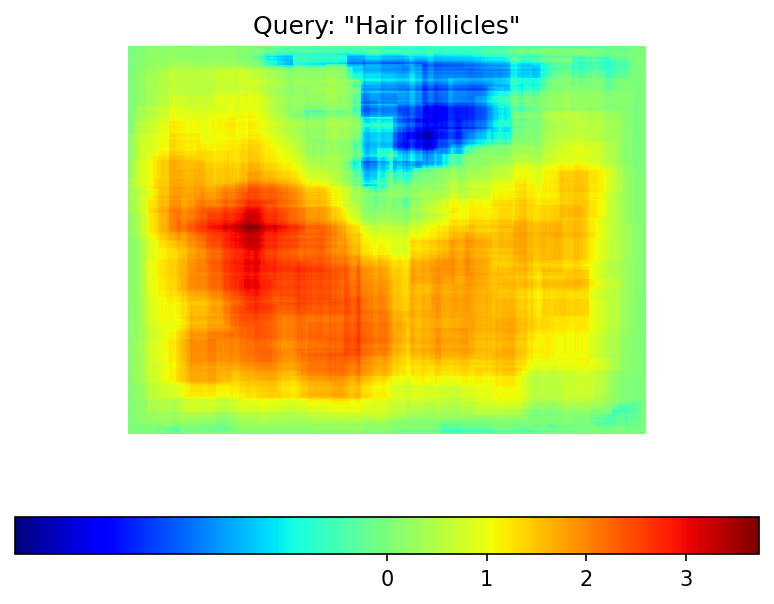

In [36]:
plt.figure(dpi=150)
plt.imshow(saliency_map, norm=colors.TwoSlopeNorm(vcenter=0), cmap='jet')
plt.colorbar(location="bottom")
plt.title(f'Query: \"{query}\"')
plt.axis("off")
plt.show()

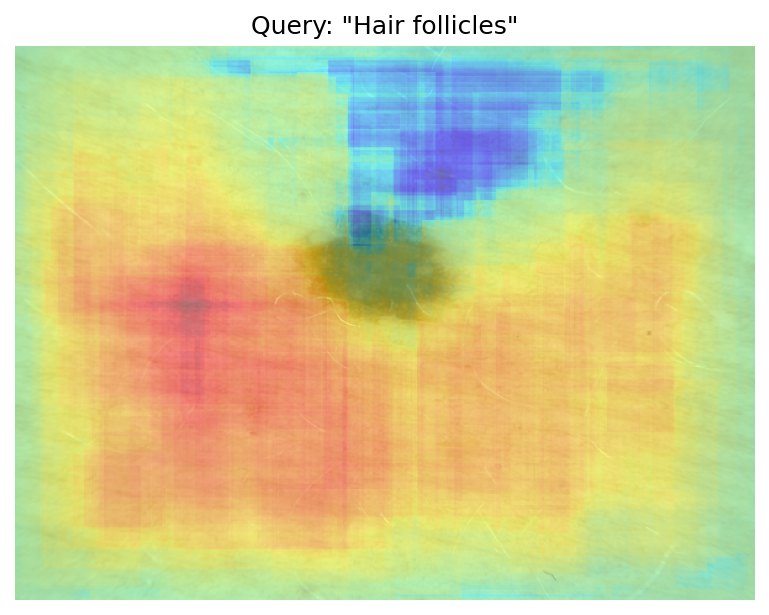

In [37]:
def plot_saliency_map(image_tensor: np.ndarray, saliency_map: np.ndarray, query: Optional[str]) -> None:
    fig = plt.figure(dpi=150)
    plt.imshow(image_tensor)
    plt.imshow(
        saliency_map,
        norm=colors.TwoSlopeNorm(vcenter=0),
        cmap="jet",
        alpha=0.5,  # make saliency map trasparent to see original picture
    )
    if query:
        plt.title(f'Query: "{query}"')
    plt.axis("off")
    return fig

plot_saliency_map(im_tensor, saliency_map, query);